## Cats and Dogs 이진 분류

### 이진분류 프로젝트

#### 개요
- 목표 : CNN으로 개와 고양이 이미지 분류 이진 분류기

#### Kaggle 데이터 다운로드
- 캐글이 뭐에요?
    - https://www.kaggle.com/
    - 예측모델 및 분석 대회 플랫폼. 2017년 구글이 인수

1. Kaggle 계정 만들기
2. 설정 집입
    - https://www.kaggle.com/settings
    - API > Create New Token 클릭 -> kaggle.json 다운로드
3. 파이썬 Kaggle 패키지 설치
    ```sheel
    ! pip install kaggle
    ```
4. kaggle.json 파일 위치
    - 리눅스/유닉스 : ~/.kaggle/kaggle.json
    - 윈도우 : %USERPROFILE%\.kaggle   
        - 사용자 폴더 아래
    - 다운로드 받은 kaggle.json를 붙여넣기
5. https://www.kaggle.com/competitions/dogs-vs-cats/overview 지입
    - Data 탭에서 Join the competition


In [12]:
! pip install kaggle


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [13]:
# 데시터셋 다운로드
! kaggle competitions download -c dogs-vs-cats

403 Client Error: Forbidden for url: https://www.kaggle.com/api/v1/competitions/data/download-all/dogs-vs-cats


#### 데이터 전처리

In [14]:
# 파이썬 모듈로드
import os, shutil, random

In [15]:
# 500개씩 샘플링 함수
def sample_data(src_dir, dst_dir, num_samples=500):
    os.makedirs(dst_dir, exist_ok=True) # 폴더 생성, exist_ok = True : 이미 존재하면 다시 만들지 않음
    all_files = [f for f in os.listdir(src_dir) if f.startswith(dst_dir.split('/')[-1])]
    samples = random.sample(all_files, num_samples)
    for f in samples:
        shutil.copy(os.path.join(src_dir, f), os.path.join(dst_dir, f))

In [ ]:
# 폴더 정리
base_dir = './data/train'   # 원본 폴더 25000개
cat_dir = './data/sample/cat'   # ./data/sample/cat/  마지막에 / 추가하면 안됨
dog_dir = './data/sample/dog'

In [17]:
os.makedirs(cat_dir, exist_ok=True)
os.makedirs(dog_dir, exist_ok=True)

In [18]:
# sample_data() 함수 사용
sample_data(base_dir, cat_dir, 500)
sample_data(base_dir, dog_dir, 500)

<img src="../image/ml0021.png" width="700">

#### 파이토치 시작

- ImageFolder 클래스 - 폴더명을 자동으로 레이블로 변환
    - cat -> 0, dog -> 1 

In [19]:
# 파이토치 모듈 로드
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

In [22]:
transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor()
])

In [23]:
train_dataset = ImageFolder('./data/sample', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

#### train_loader 시각화

In [25]:
# 시각화용 모듈 로드
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [26]:
# 한글로 Matplotlib 사용시 항상 필요
from matplotlib import rcParams, font_manager, rc

font_path = 'C:/Windows/Fonts/malgun.ttf'
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)
rcParams['axes.unicode_minus'] = False

sns.set_style('darkgrid')
sns.set_theme(font='Malgun Gothic', rc={'axes.unicode_minus': False})

In [27]:
# 배치 하나 꺼내기
images, labels = next(iter(train_loader))

In [29]:
class_name = ['cat', 'dog']

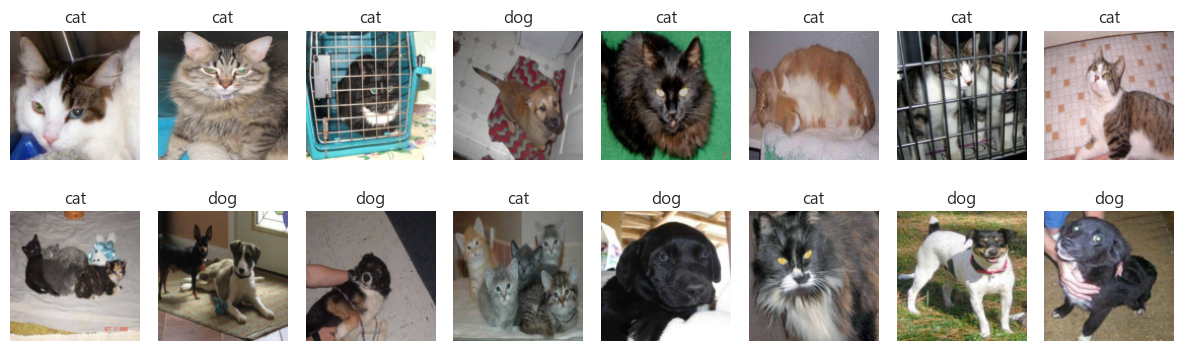

In [35]:
# 시각화
plt.figure(figsize=(12,4))
for i in range(16): # 32개 중 반만 표현
    plt.subplot(2,8,i+1)
    img = images[i].permute(1,2,0)  # 컬러 채널이기 때문에 matplotlib 표현시 순서 변경
    plt.imshow(img)
    plt.title(f'{class_name[labels[i].item()]}')
    plt.axis('off')

plt.tight_layout()

#### CNN 모델 정의

In [42]:
# 사용 모듈 로드
import torch
import torch.nn as nn
import torch.nn.functional as F

In [45]:
# 클래스 정의
class CatDogCNN(nn.Module):
    def __init__(self):
        super(CatDogCNN,self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)  # conv1, conv2 모두 사용
        self.conv2 = nn.Conv2d(32,64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 32 * 32, 128)  # MaxPool(128) -> MaxPool(64) -> 32x32
        self.fc2 = nn.Linear(128, 1)    # 마지막 분류가 0, 1 

    def forward(self,x):
        # conv -> activation -> maxpooling 2회실시
        # dense 1,2 통과
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 32 * 32)    # flattern -> 1차원 배열화, 65, 536개 입력
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))  # F.sigmoid() deprecated
        return x

#### 훈련

In [46]:
# cuda 준비 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CatDogCNN().to(device)
criterion = nn.BCELoss()    # Binary Cross Entropy 손실 함수
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [51]:
# 훈련함수
def train(model, loader, criterion, optimizer):
    model.train()   # 훈련모드
    total_loss = 0
    for images, labels in loader:
        images, labels = images.to(device), labels.float().to(device).unsqueeze(1)  # 1 ,0 -> [1,], [0,]
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(loader)


In [52]:
# 훈련
EPOCH = 10

for epoch in range(EPOCH):
    loss = train(model, train_loader,criterion, optimizer)
    print(f'{epoch+1}/{EPOCH}] LOSS: {loss:.4f}')

1/10] LOSS: 0.2160
2/10] LOSS: 0.1357
3/10] LOSS: 0.0922
4/10] LOSS: 0.0574
5/10] LOSS: 0.0246
6/10] LOSS: 0.0134
7/10] LOSS: 0.0072
8/10] LOSS: 0.0050
9/10] LOSS: 0.0036
10/10] LOSS: 0.0028


#### 예측결과 시각화

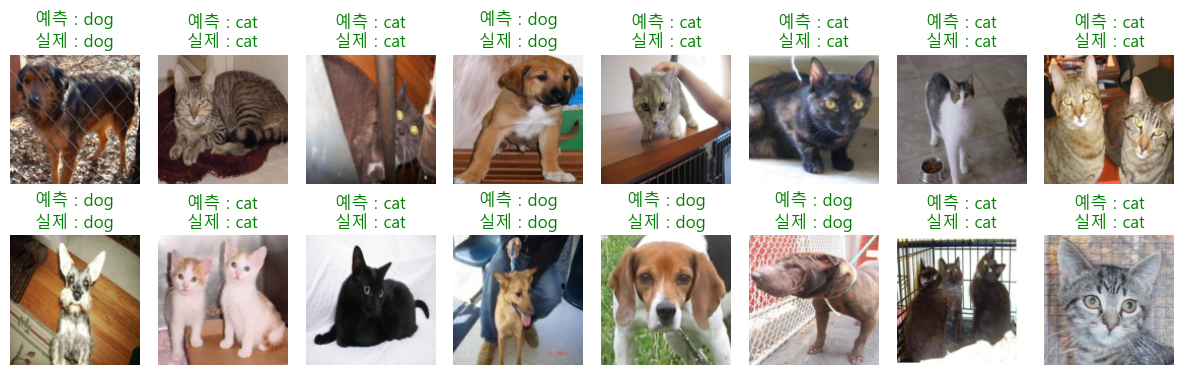

In [58]:
# 검증
model.eval()
images,labels = next(iter(train_loader))
images = images.to(device)
with torch.no_grad():
    outputs = model(images)
    preds = (outputs > 0.5).int().cpu().squeeze()

plt.figure(figsize=(12,4))
for i in range(16):
    plt.subplot(2,8,i+1)
    plt.imshow(images[i].cpu().permute(1,2,0))
    pred_label = 'dog' if preds[i] == 1 else 'cat'
    true_label = 'dog' if labels[i] == 1 else 'cat'
    color = 'green' if pred_label == true_label else 'red'

    plt.title(f'예측 : {pred_label}\n실제 : {true_label}', color=color)
    plt.axis('off')

plt.tight_layout()
plt.show()

#### 모델 저장/ 불러오기

In [63]:
# 가중치만 저장
torch.save(model.state_dict(), './catdog_weight.pth')

In [64]:
# a모델 전제 저장
torch.save(model,'./catdog_model.pth')

In [68]:
# 가중치만 불러올 때
model2 = CatDogCNN().to(device)
model2.load_state_dict(torch.load('./catdog_weight.pth',map_location=device))
model2

CatDogCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=65536, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
)

#### 테스트 이미지로 테스트
- 1.jpg ~ 1200.jpg 까지 Dog,Cat 구분

In [69]:
# 필요 묘둘로드
import torch
from torchvision import transforms
from PIL import Image

In [ ]:
# transform 위 선언
img = Image.open('./data/test/2567.jpg').convert('RGB')
img_tensor = transform(img).unsqueeze(0) # [3,128,128] -> [1,3,128,128] 4차원 텐서로 변경
# print(img_tensor)
img.show()      # 기본 이미지뷰 프로그램으로 표현

tensor([[[[0.4588, 0.4902, 0.5569,  ..., 0.9961, 0.9961, 0.9961],
          [0.4627, 0.4745, 0.5490,  ..., 0.9961, 0.9961, 0.9922],
          [0.4902, 0.4745, 0.5529,  ..., 0.9961, 0.9961, 0.9882],
          ...,
          [0.2588, 0.3059, 0.5961,  ..., 0.8706, 0.8000, 0.7804],
          [0.2784, 0.3216, 0.5882,  ..., 0.8745, 0.8353, 0.7804],
          [0.3922, 0.4000, 0.6118,  ..., 0.8824, 0.8392, 0.7608]],

         [[0.4549, 0.4824, 0.5490,  ..., 0.9961, 0.9961, 0.9961],
          [0.4588, 0.4706, 0.5412,  ..., 0.9961, 0.9961, 0.9922],
          [0.4863, 0.4667, 0.5451,  ..., 0.9961, 0.9961, 0.9882],
          ...,
          [0.2235, 0.2588, 0.5686,  ..., 0.8745, 0.8000, 0.7843],
          [0.2471, 0.2784, 0.5608,  ..., 0.8784, 0.8392, 0.7922],
          [0.3686, 0.3608, 0.5843,  ..., 0.8863, 0.8431, 0.7725]],

         [[0.4431, 0.4784, 0.5569,  ..., 0.9961, 0.9961, 0.9961],
          [0.4431, 0.4667, 0.5490,  ..., 0.9961, 0.9961, 0.9922],
          [0.4706, 0.4627, 0.5529,  ..., 0

In [74]:
model

CatDogCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=65536, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
)

In [80]:
model.eval()        # 예측, 평가 모드로

with torch.no_grad():
    output = model(img_tensor.to(device))
    pred = (output > 0.5).int().item()

'Dog' if pred == 1 else 'Cat'

'Cat'

#### 폴더로 여러개 테스트

In [81]:
import os

In [82]:
test_dir = './data/test'
images_files = [f for f in os.listdir(test_dir) if f.endswith(('.jpg', '.png'))]

In [83]:
len(images_files)

12500

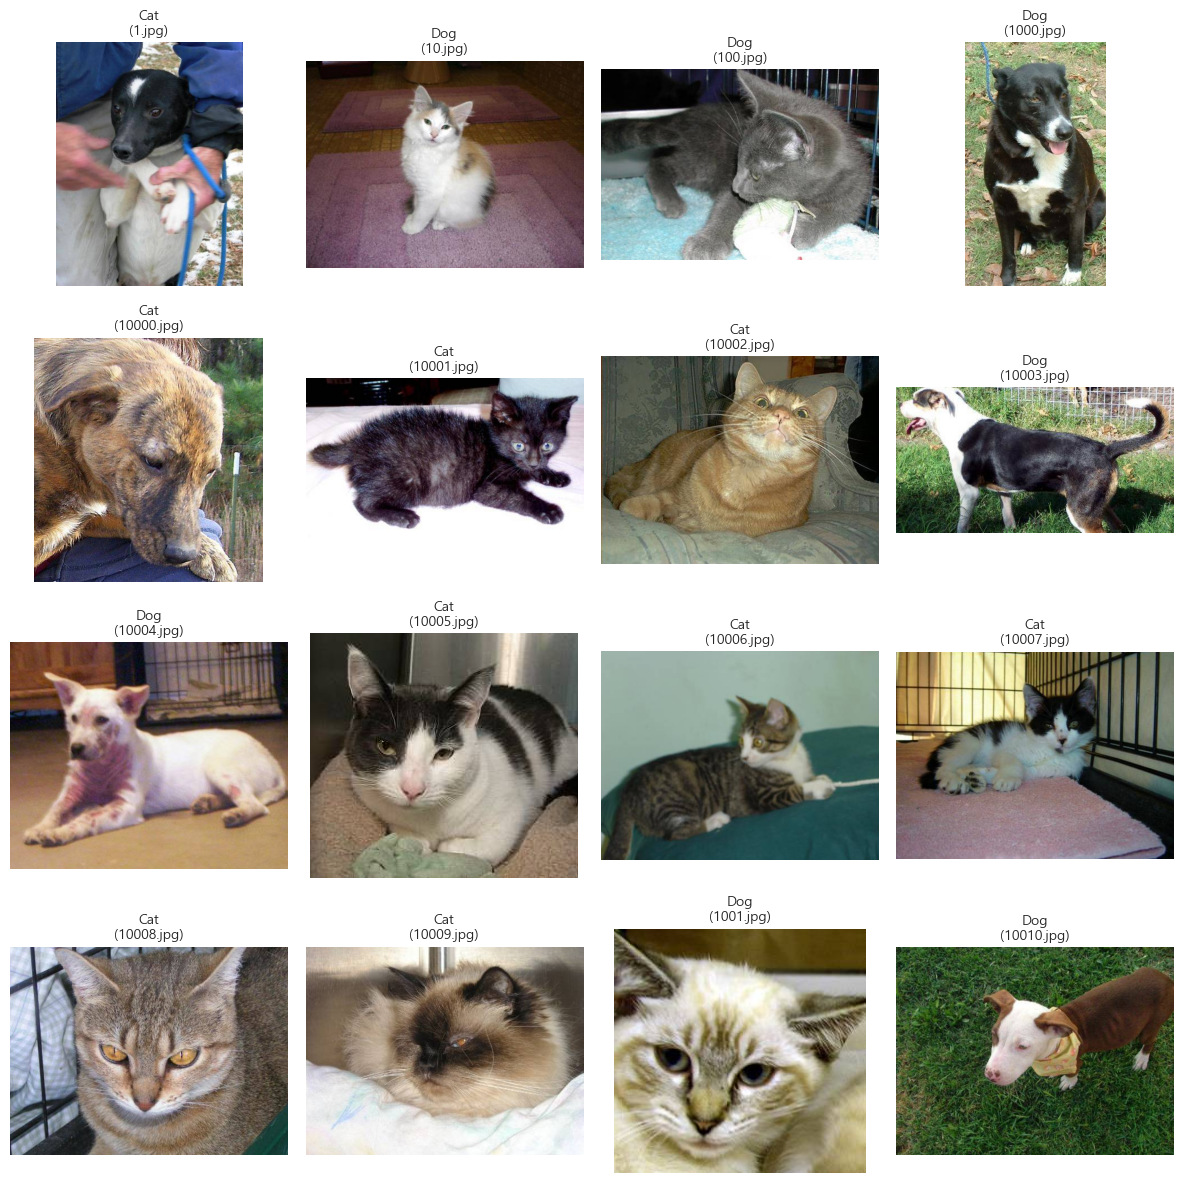

In [84]:
# 예측과 시각화 동시
plt.figure(figsize=(12,12))
for i, fname in enumerate(images_files[0:16]):   # 최대 16장까지 출력 0:16,16:32,32:48
    img_path = os.path.join(test_dir, fname)
    img = Image.open(img_path).convert('RGB')
    img_tensor = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(img_tensor)
        pred= 'Dog' if output.item() > 0.5 else 'Cat'

    # 이미지 출력
    plt.subplot(4,4,i+1)
    plt.imshow(img)
    plt.title(f'{pred}\n({fname})', fontsize = 10)
    plt.axis('off')

plt.tight_layout()
plt.show()

### Kaggle Competitions 도전

- 캐글상에선 경로 등이 윈도우와 다르기 때문에 설정 변경이 필요

#### 캐글 순서

1. Data > Join the Competition
2. Code > New Notebook 클릭 (코랩과 동일)
3. 노트북 작성
4. 캐글 서버내 압축파일 처리부분만 새로 코딩
5. 위의 소스 그대로 사용가능
6. submission.csv 만드는 코드 추가
7. submission.csv 제출

#### 캐글 GPU
- 캐글 노트북 Settings > Accelerator > GPU T4 x2, GPU P1000으로 GPU 사용가능 (1주에 30시간 제한)